# Инфракрасная фурье-спектроскопия
# Курсовой проект по теме
## «Разработка и реализация методов и алгоритмов анализа химических соединений по их инфракрасным спектрам»
### Сафроненков Роман, ФН4-31М, Вариант №10

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from tqdm.notebook import tqdm
from scipy.interpolate import interp1d
from scipy import optimize
from jcamp import JCAMP_reader
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import roc_curve, roc_auc_score

## Задание №1

In [2]:
def read_jdx(code, path):
    '''
    Функция для чтения .jdx файлов, принимает на вход код CAS-код и папку,
    в которой нужно искать этот файл, возвращает содержание файла
    '''
    assert os.path.exists(path + '/' + code), "Такого файла нет"
    result = JCAMP_reader(path + '/' + code)
    return result

def plot_specs_together(code_to_content_dict, save=False, savepath='results', title='1', format_='png'):
    '''
    Функция для отрисовки всех спектров из базы
    '''
    fig, ax = plt.subplots(len(code_to_content_dict.keys()) // 2, 2, figsize=(20, 30))
    for i, j in enumerate(code_to_content_dict.values()):
        ax[i // 2][i % 2].set_title(j['title'].lower(), fontsize=15)
        ax[i // 2][i % 2].plot(j['x'], j['y'])
        ax[i // 2][i % 2].grid(True)
        ax[i // 2][i % 2].set_xlabel(j['xunits'].lower(), fontsize=15)
        ax[i // 2][i % 2].set_ylabel(j['yunits'].lower(), fontsize=15)
        plt.tight_layout()
    plt.show()
    if save:
        try:
            fig.savefig('./' + savepath + '/' + title + '.' + format_, dpi=600, format=format_)
        except FileNotFoundError:
            os.mkdir('./' + savepath)
            fig.savefig('./' + savepath + '/' + title + '.' + format_, dpi=600, format=format_)
        
def x_to_new_grid(code_to_content_dict, new_grid_range):
    '''
    Функция для построения новой сетки x, возвращает новую сетку
    '''
    xfactors = [code_to_content_dict[i]['xfactor'] for i in code_to_content_dict.keys()]
    xfactor = max(xfactors)
    new_grid = np.arange(new_grid_range[0], new_grid_range[1], xfactor)
    return new_grid

def make_code_to_content_dict(path):
    '''
    Функция для создания словаря вида: "КОД:СОДЕРЖАНИЕ ФАЙЛА",
    возвращает словарь
    '''
    code_to_content = {}
    for i in os.listdir(path):
        code = re.findall('(\d+-\d+-\d+)', i)[0] # для того, чтобы код выглядел без -IR.jdx
        result = read_jdx(i, path)
        code_to_content[code] = result
    return code_to_content

In [3]:
def interpolate(x, y, new_x):
    '''
    Функция для интерполяции с использованием scipy.interpolate.interp1d
    '''
    f = interp1d(x, y)
    return f(new_x)

In [4]:
def make_new_content_dict(content_dict):
    '''
    Функция для создания нового словаря для спектров, приведенных к
    пропусканию, отмасштабированных, приведенных к новой сетке
    '''
    new_content = {}
    for i, j in content_dict.items():
        new_content[i] = dict()
        new_content[i]['x'] = j['x']
        new_content[i]['title'] = j['title']
        new_content[i]['xunits'] = j['xunits']
        # поменяем все спектры на пропускание
        if j['yunits'] == 'ABSORBANCE':
            new_content[i]['y'] = np.exp(-j['y'])
            new_content[i]['yunits'] = 'TRANSMITTANCE'
        else:
            new_content[i]['y'] = j['y']
            new_content[i]['yunits'] = j['yunits']
        # отмасштабируем
        new_content[i]['y'] = new_content[i]['y'] / np.max(new_content[i]['y'])
        # отсекаем, если больше 0.8
        if np.min(j['y']) <= 0.2:
            new_content[i]['y'] = (1 - 0.8 / (1 - np.min(new_content[i]['y'])) * (1 - new_content[i]['y']))
        # создадим новую сетку
        new_x = x_to_new_grid(content_dict, [600, 3600])
        # интерполируем новые значения интенсивности
        new_content[i]['y'] = interpolate(new_content[i]['x'], new_content[i]['y'], new_x)
        new_content[i]['x'] = new_x
    return new_content

In [5]:
code_to_content = make_code_to_content_dict('content')

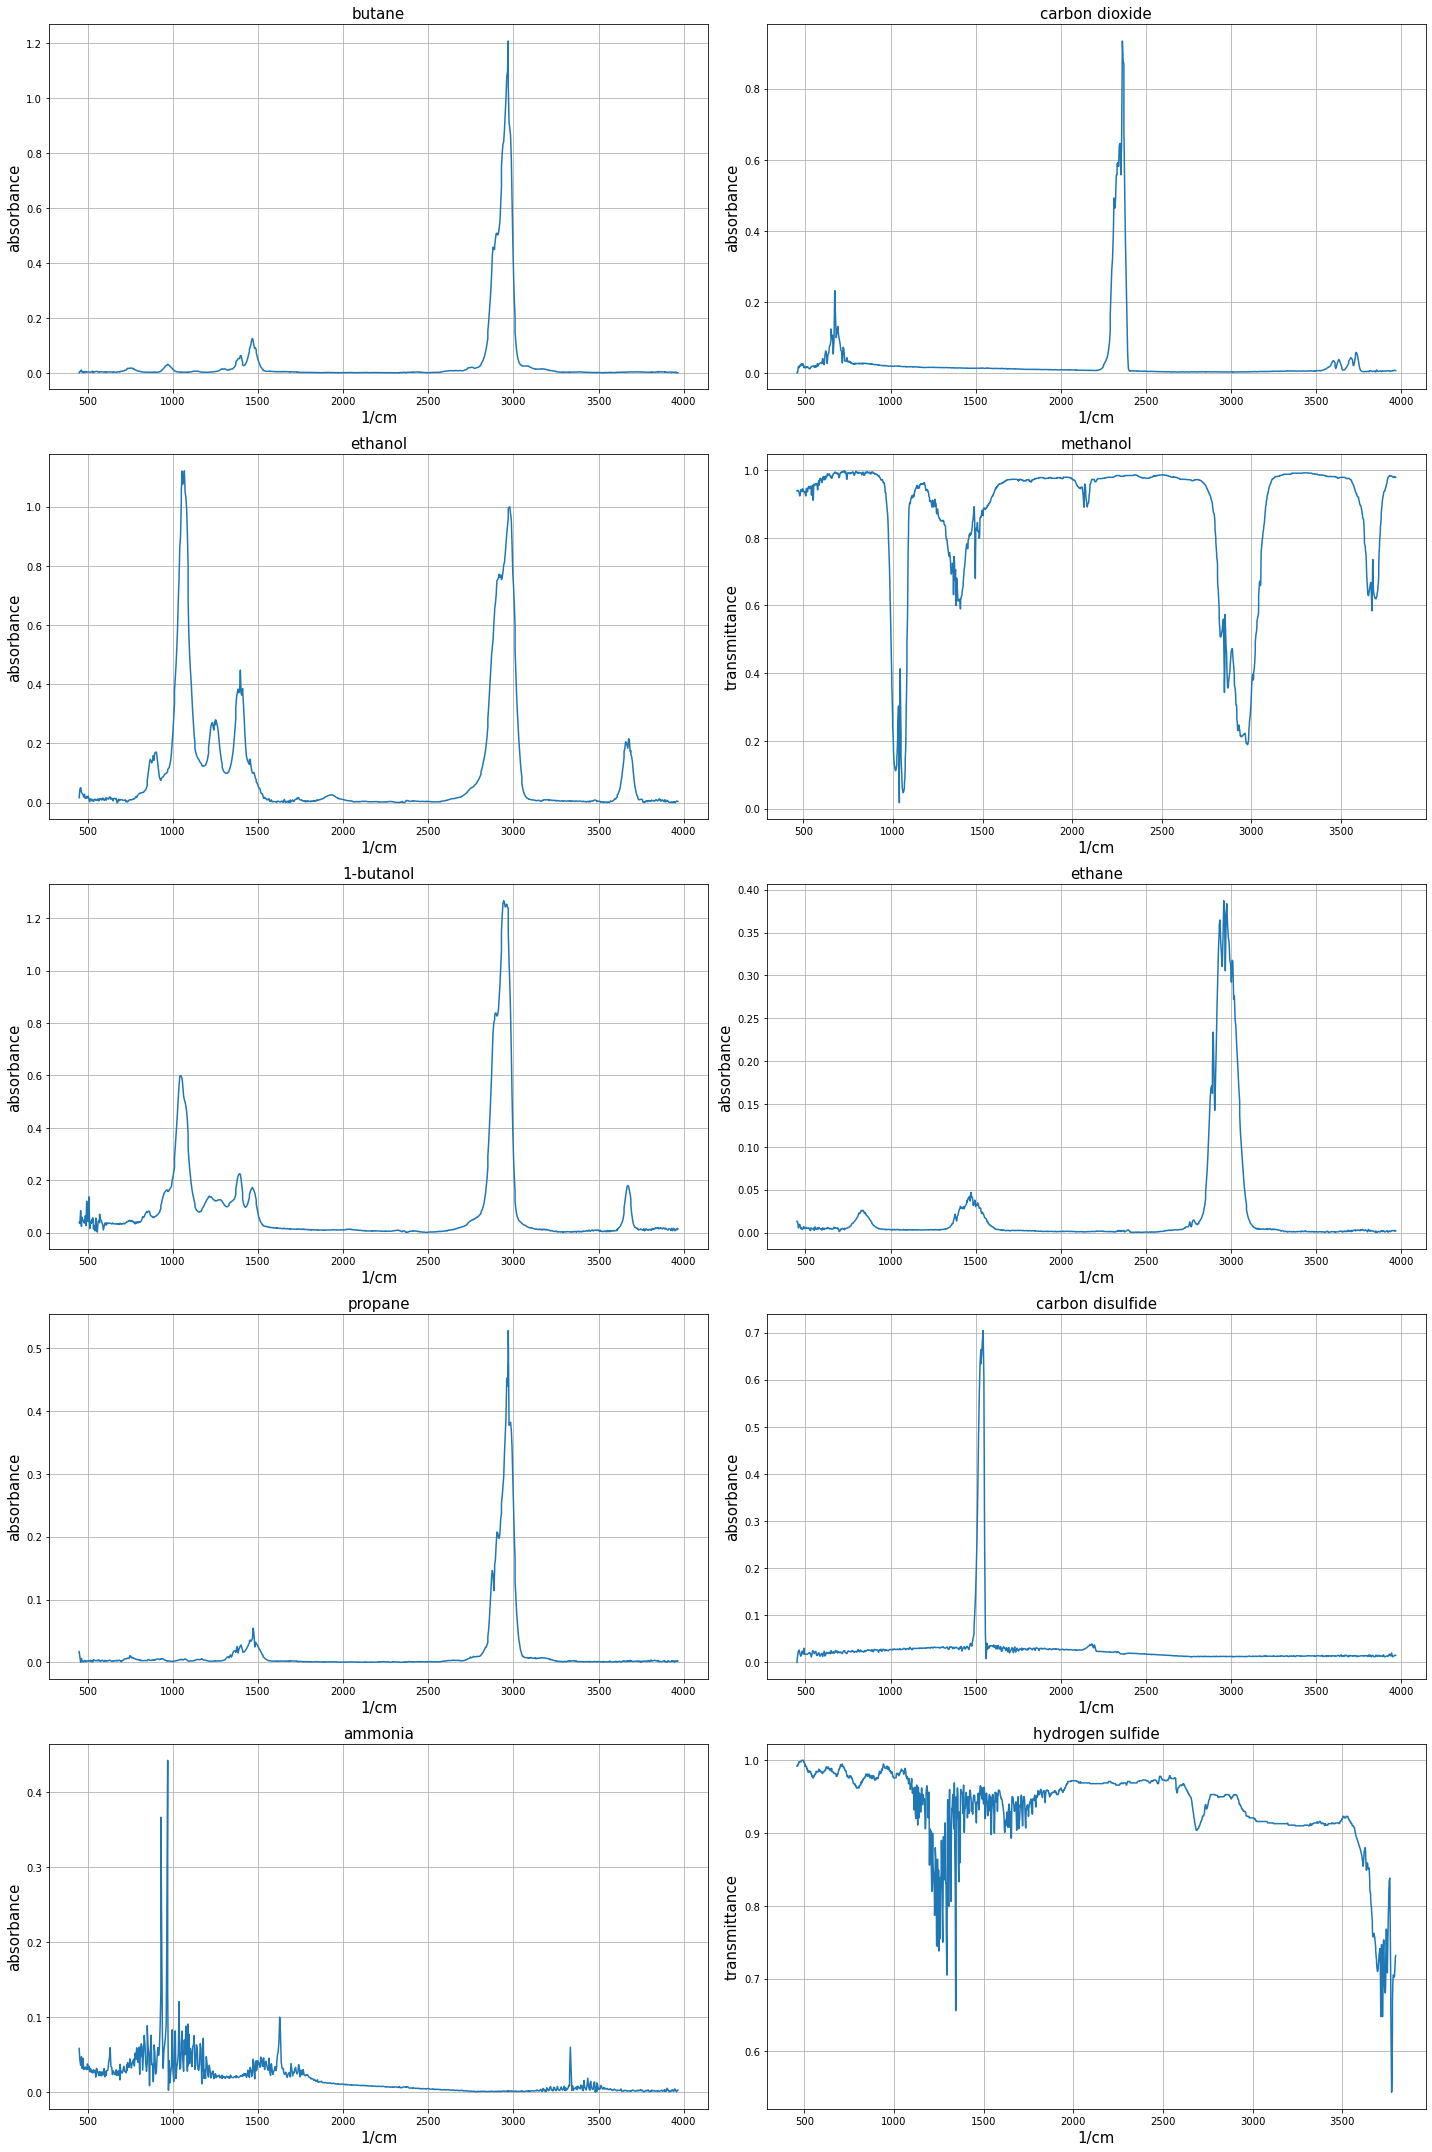

In [6]:
plot_specs_together(code_to_content, save=False)

In [7]:
new_content = make_new_content_dict(code_to_content)

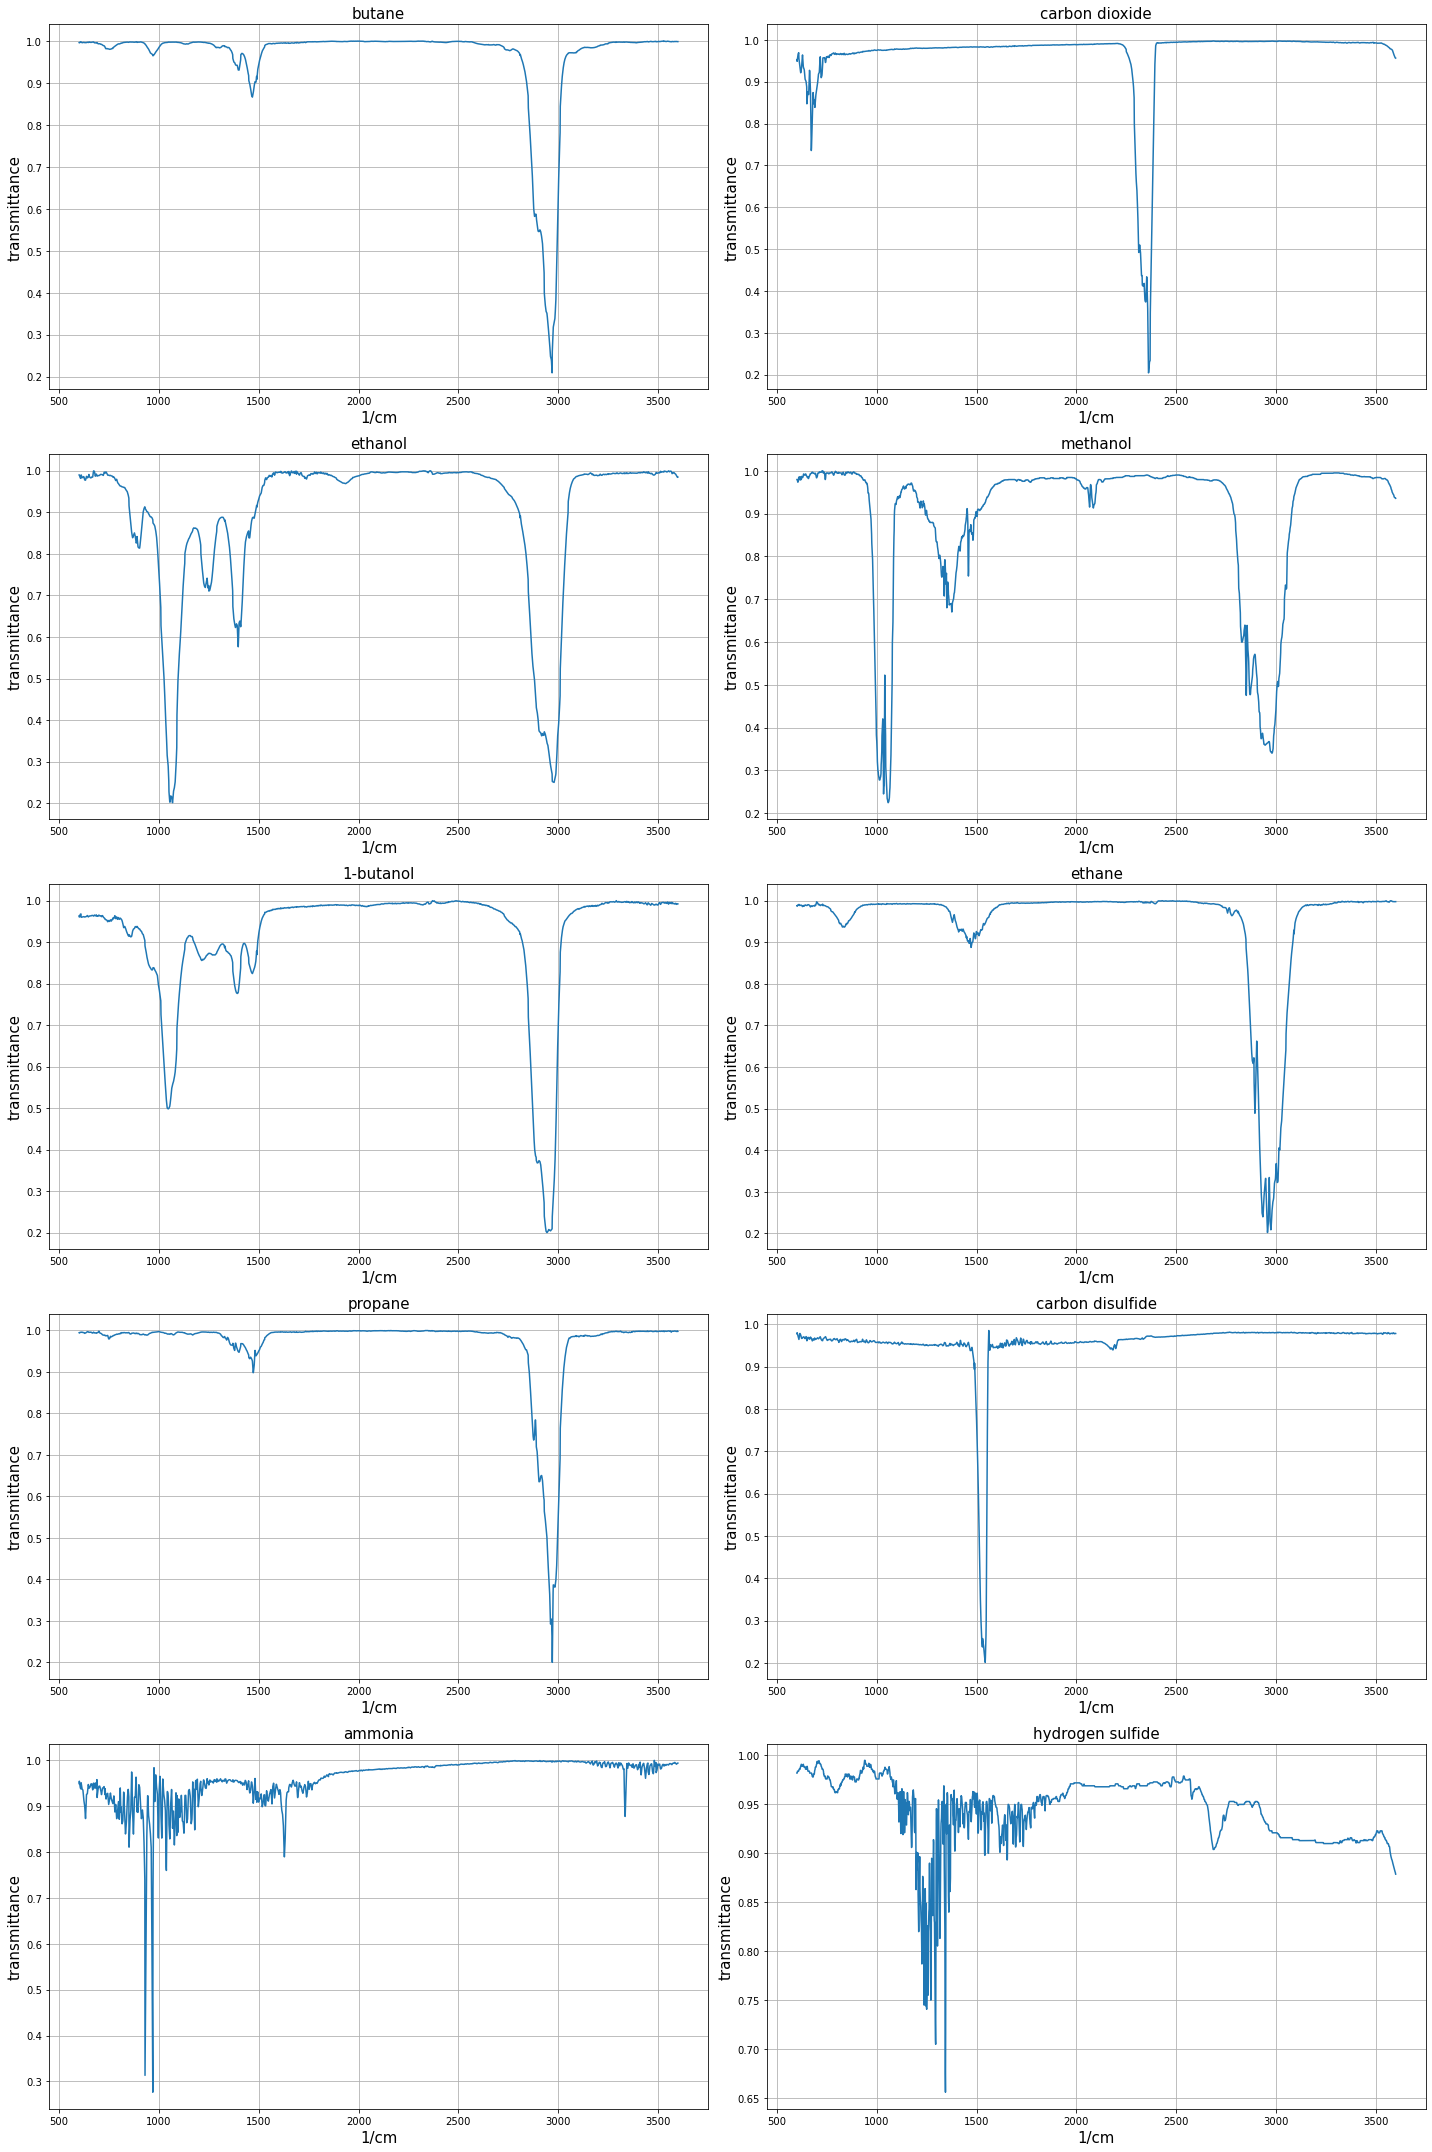

In [8]:
plot_specs_together(new_content, save=True)

In [9]:
specs = pd.DataFrame({j['title'].lower():j['y'] for i, j in new_content.items()})
specs['x'] = new_content['106-97-8']['x']
specs

,butane,carbon dioxide,ethanol,methanol,1-butanol,ethane,propane,carbon disulfide,ammonia,hydrogen sulfide,x
0,0.995978,0.952757,0.989668,0.979608,0.963447,0.987874,0.994628,0.977899,0.948527,0.982000,600.0
1,0.995514,0.948684,0.989312,0.979608,0.960428,0.986404,0.993726,0.980245,0.953844,0.982000,601.0
2,0.995875,0.951756,0.987879,0.979218,0.961485,0.986990,0.993975,0.978793,0.951458,0.982406,602.0
3,0.996338,0.955722,0.986311,0.977600,0.963051,0.987832,0.994368,0.976866,0.948109,0.984000,603.0
4,0.996802,0.959688,0.984744,0.974120,0.964617,0.988675,0.994761,0.974939,0.944760,0.984000,604.0
...,...,...,...,...,...,...,...,...,...,...,...
2995,0.998554,0.958893,0.985293,0.937194,0.992056,0.997517,0.998456,0.978333,0.992255,0.881595,3595.0
2996,0.998431,0.957765,0.984287,0.937194,0.992434,0.997560,0.998827,0.978580,0.992809,0.881167,3596.0
2997,0.998369,0.956915,0.983744,0.937194,0.992623,0.997589,0.998888,0.978695,0.993187,0.880740,3597.0
2998,0.998431,0.956621,0.984129,0.936727,0.992434,0.997589,0.998333,0.978547,0.993209,0.879582,3598.0


In [10]:
del(code_to_content, new_content)

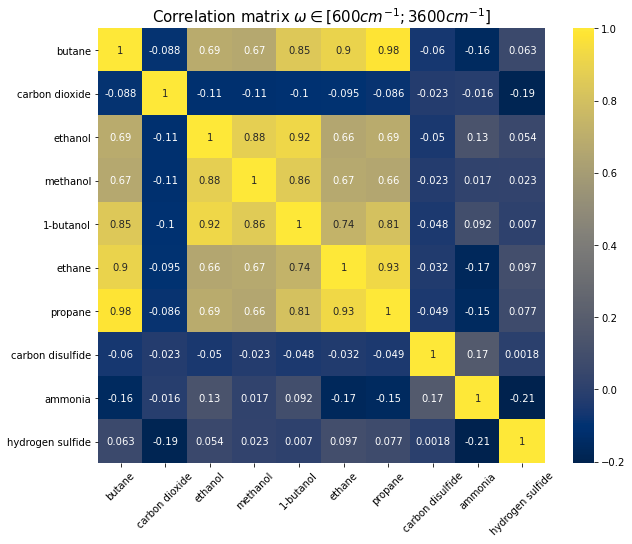

In [11]:
fig = plt.figure(figsize=(10.0, 8.0))
ax = plt.axes()
sns.heatmap(specs.drop('x', axis=1).corr(), cmap='cividis', annot=True, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Correlation matrix $\omega\in[600cm^{-1};3600cm^{-1}]$', fontsize=15)
plt.show()
# fig.savefig('./results/corr.png', dpi=600, format='png')

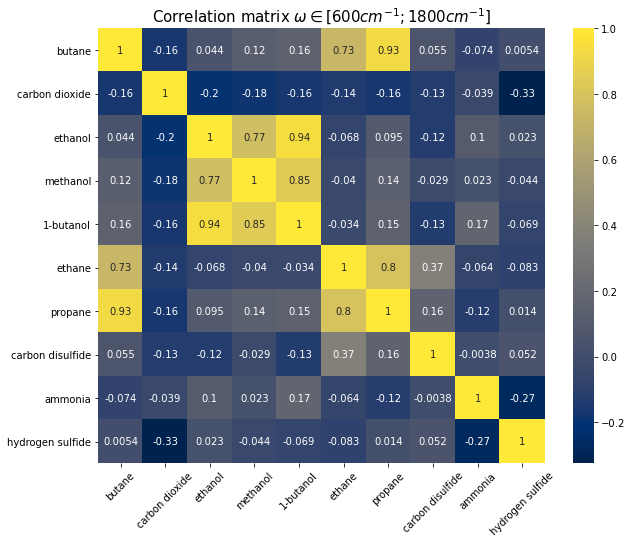

In [12]:
fig = plt.figure(figsize=(10.0, 8.0))
ax = plt.axes()
sns.heatmap(specs.drop('x', axis=1).iloc[:1201].corr(), cmap='cividis', annot=True, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Correlation matrix $\omega\in[600cm^{-1};1800cm^{-1}]$', fontsize=15)
plt.show()
# fig.savefig('./results/corr1.png', dpi=600, format='png')

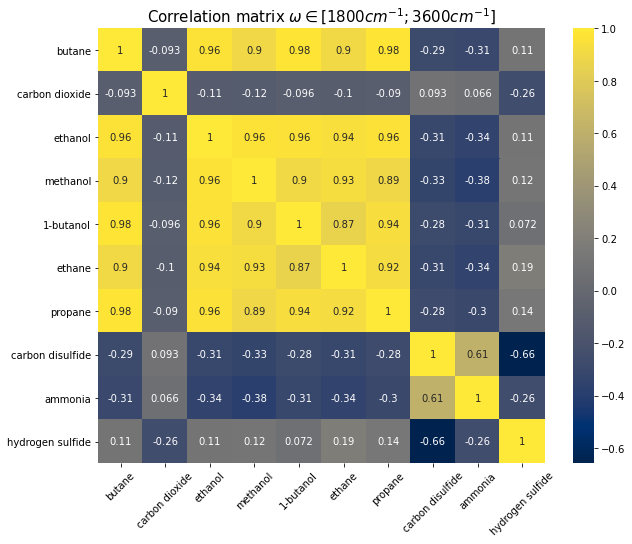

In [13]:
fig = plt.figure(figsize=(10.0, 8.0))
ax = plt.axes()
sns.heatmap(specs.drop('x', axis=1).iloc[1201:].corr(), cmap='cividis', annot=True, ax=ax)
plt.xticks(rotation=45)
ax.set_title('Correlation matrix $\omega\in[1800cm^{-1};3600cm^{-1}]$', fontsize=15)
plt.show()
# fig.savefig('./results/corr2.png', dpi=600, format='png')

## Задание №2
### Примем концентрации веществ в базе данных за $100мг/м^{2}$

In [14]:
def make_noised(intens, snr, random_state=None):
    '''
    Функция для создания зашумленного спектра с SNR (он же - отношение дисперсий)
    '''
    if random_state:
        np.random.seed(random_state)
    amp = np.max(1 - intens)
    result = intens + np.random.normal(0, (amp / snr), size=len(intens))
    return result
#     return intens + np.random.normal(0, np.sqrt(np.var(intens) / snr), size=len(intens))

In [15]:
def least_squares_weight(X, y):
    '''
    Матричный метод наименьших квадратов
    '''
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

In [16]:
class substance_predictor:
    '''
    Класс для предсказания вещества по его спектру, принимает на вход спектр,
    базу данных спектров, тип оптимизации, истинное значение концентрации (для предсказания) и
    концентрацию веществ в базе данных
    '''
    
    def __init__(self, sample, database, minimize_type, c_true, c_database=100):
        assert minimize_type in {'gd', 'bas'}
        assert type(c_true) in {int, list}
        
        sample_ = -np.log(sample.copy())
        self.sample = 100 * sample_
        database_ = database.copy().values
        self.database = -np.log(database_)
        self.type = minimize_type
        self.c_database = c_database
        self.substances = database.columns
        self.c_true = c_true
        
    def init_start_point(self):
        '''
        Инициализация начальной точки для алгоритмов оптимизации
        '''
        return np.zeros(shape=self.database.shape[1])
            
    def loss_function(self, c, X, y):
        '''
        Фукнция потерь MSE
        '''
        return np.mean((y.reshape(-1, 1) - X.dot(c.reshape(-1, 1))) ** 2)
    
    def grad(self, c, X, y):
        '''
        Градиент MSE
        '''
        grad = -2 * X.T.dot((y.reshape(-1, 1) - X.dot(c.reshape(-1, 1)))) / X.shape[0]
        return grad.reshape(-1)
    
    def gradient_descent(self, lr=0.3, iterations=100000):
        '''
        Реализация градиентного спуска, глобальные параметры:
        lr - learning rate, он же скорость обучения
        iterations - количество итераций
        '''
        self.c = self.init_start_point()
        for _ in range(iterations):
            gradient = self.grad(self.c.copy(), self.database, self.sample)
            self.c -= lr * gradient
    
    def basinhopping(self):
        '''
        Реализация отжига с использованием scipy
        '''
        self.c = self.init_start_point()
        optimizer = optimize.basinhopping(self.loss_function, x0=self.c, minimizer_kwargs={"method": "BFGS",
                                                                                     'args':(self.database, self.sample)},
                                    niter=30)
        self.c = optimizer.x
    
    def fit(self):
        '''
        Функция для запуска поиска минимума
        '''
        if self.type == 'gd':
            self.gradient_descent()
        elif self.type == 'bas':
            self.basinhopping()
            
    def error(self, true, predict):
        '''
        Относительная ошибка в %
        '''
        return np.round(np.abs(true - predict) / true * 100, 3)
            
    def predict(self):
        '''
        Вывод на экран предсказания и относительной ошибки, для задания 2 используется 
        одна концентрация, для задания 3 список концентраций, для этого стоит условный оператор
        '''
        print('Метод:{}'.format('Градиентный спуск' if self.type == 'gd' else 'Отжиг'))
        if type(self.c_true) == int:
            print('Вещество:{},\nКонцентрация:{}\nОтносительная ошибка:{}%'.format(self.substances[np.argmax(self.c)],
                                                                             np.max(self.c),
                                                                             self.error(self.c_true, np.max(self.c))))
        elif type(self.c_true) == list:
            concentrations = sorted(self.c, reverse=True)[:len(self.c_true)]
            for i in range(len(concentrations)):
                
                print('Вещество:{},\nКонцентрация:{}\nОтносительная ошибка:{}%'\
                      .format(self.substances[np.where(self.c == concentrations[i])[0][0]],
                              concentrations[i], self.error(sorted(self.c_true, reverse=True)[i], concentrations[i])))
                print(20*'~')

In [17]:
sample = specs['butane'].values
sample = -np.log(sample)
sample = np.exp(-10 / 100 * sample)

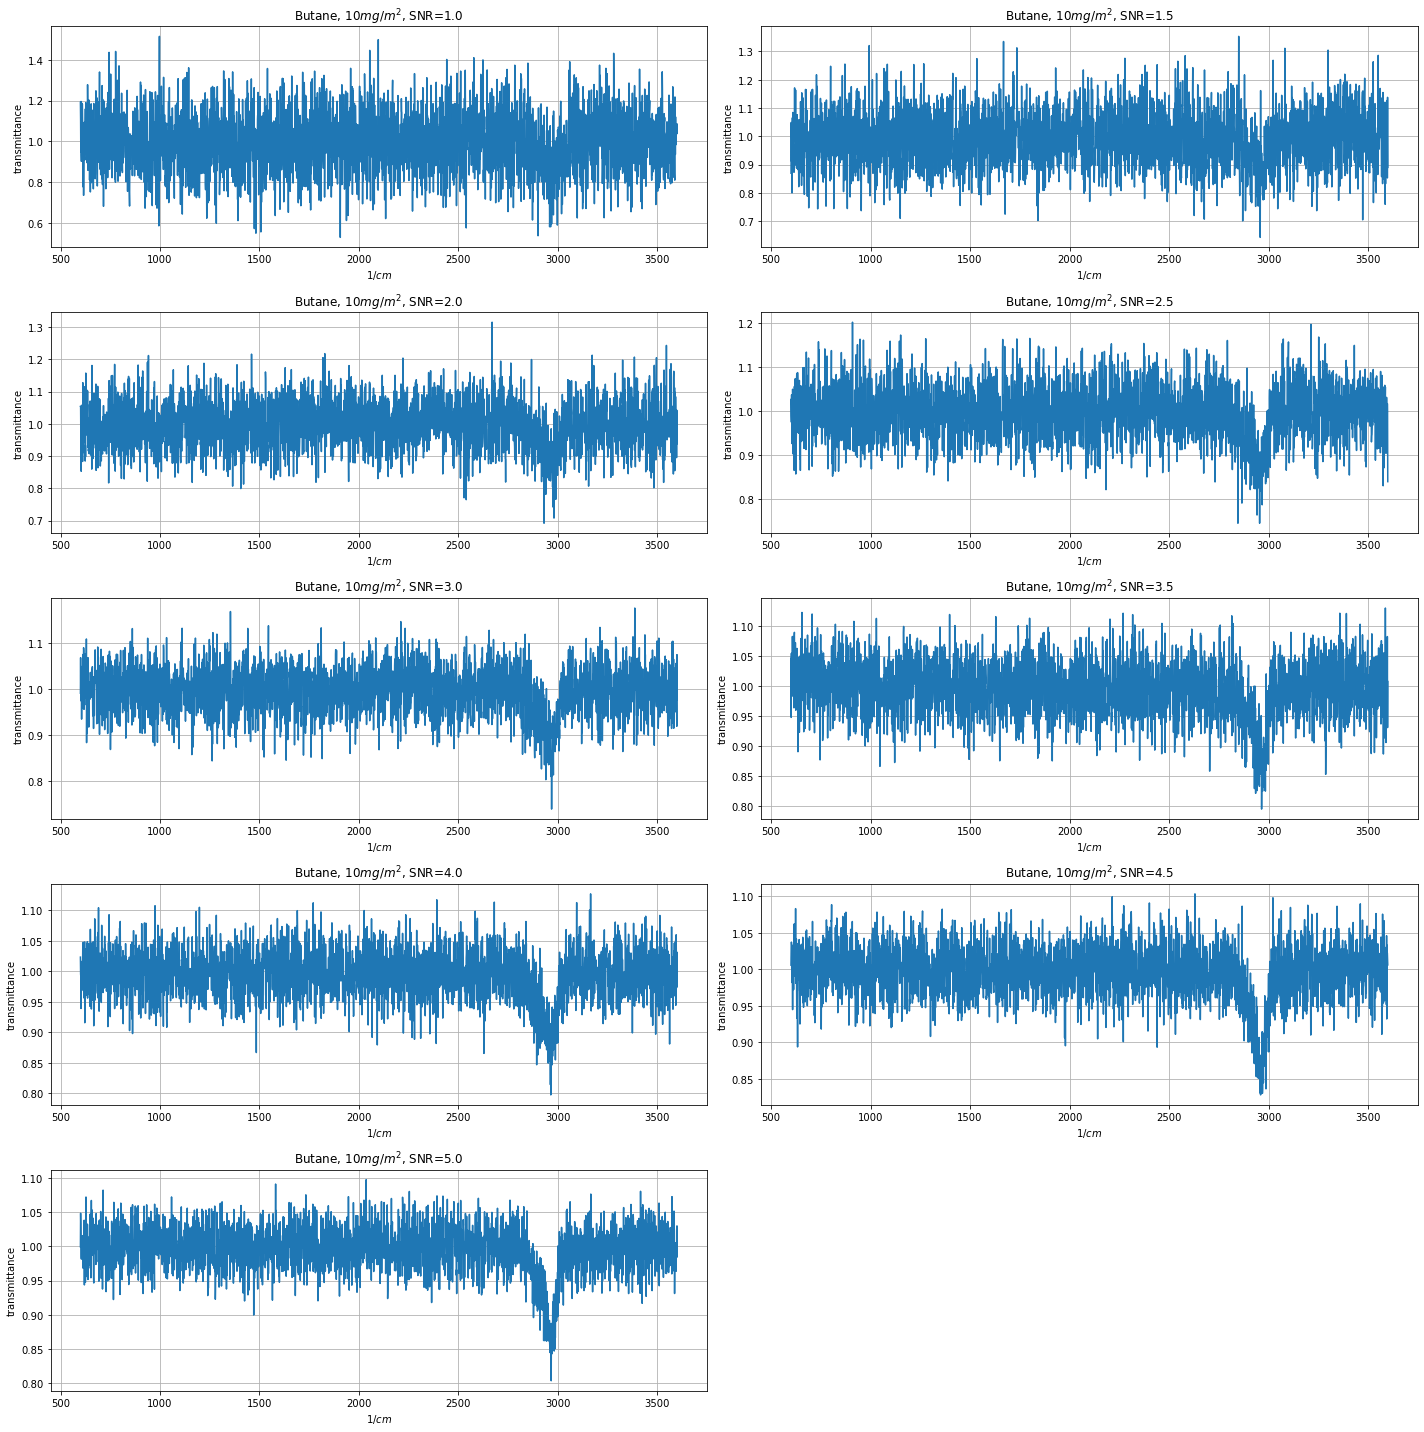

In [18]:
snr_range = np.arange(1, 5.5, 0.5)
fig, ax = plt.subplots(len(snr_range) // 2 if len(snr_range) % 2 == 0 else len(snr_range) // 2 + 1,
                       2, figsize=(20.0, 20.0))
for i in range(len(snr_range)):
    ax[i // 2][i % 2].plot(specs['x'].values, make_noised(sample, snr_range[i]))
    ax[i // 2][i % 2].set_title('Butane, $10mg/m^2$, SNR={}'.format(snr_range[i]))
    ax[i // 2][i % 2].set_xlabel('$1/cm$')
    ax[i // 2][i % 2].set_ylabel('transmittance')
    ax[i // 2][i % 2].grid(True)
    plt.tight_layout()
    
ax[i // 2][i % 2 + 1].remove() # так как графиков 9, а сетка у нас из 10, удалим последний пустой график
# fig.savefig('./results/task2.png', dpi=600, format='png')

In [19]:
sample = make_noised(sample, 2, random_state=1)

In [20]:
print('Аналитическое решение методом наименьших квадратов:\n', \
      least_squares_weight(-np.log(specs.drop('x', axis=1).values), 100 * -np.log(sample)))

Аналитическое решение методом наименьших квадратов:
 [ 9.8592321   0.36342097 -1.71774606 -0.16606839  3.34184228 -0.23652018
 -1.26718905 -0.8994078  -0.44151678  2.96624971]


In [21]:
pred_grad = substance_predictor(sample=sample, database=specs.drop('x', axis=1), minimize_type='gd', c_true=10)

In [22]:
pred_grad.fit()

In [23]:
pred_grad.predict()

Метод:Градиентный спуск
Вещество:butane,
Концентрация:9.85626861506852
Относительная ошибка:1.437%


In [24]:
pred_bas = substance_predictor(sample=sample, database=specs.drop('x', axis=1), minimize_type='bas', c_true=10)

In [25]:
pred_bas.fit()

In [26]:
pred_bas.predict()

Метод:Отжиг
Вещество:butane,
Концентрация:9.860519089869129
Относительная ошибка:1.395%


In [27]:
for sp in specs.columns.tolist()[:-1]:
    # создадим зашумленный спектр для каждого вещества
    sample = specs[sp].values
    sample = -np.log(sample)
    sample = np.exp(-10 / 100 * sample)
    sample = make_noised(sample, 2)
    # создадим объект предсказателя вещества и его концентрации методом градиентного спуска
    pred_grad = substance_predictor(sample=sample, database=specs.drop('x', axis=1), minimize_type='gd', c_true=10)
    pred_grad.fit()
    print('Для вещества {} с концентрацией {}, такое предсказание:'.format(sp, 10))
    pred_grad.predict()
    print(20*'~')
    # создадим объект предсказателя вещества и его концентрации методом отжига
    pred_bas = substance_predictor(sample=sample, database=specs.drop('x', axis=1), minimize_type='bas', c_true=10)
    pred_bas.fit()
    pred_bas.predict()
    print(40*'-')

Для вещества butane с концентрацией 10, такое предсказание:
Метод:Градиентный спуск
Вещество:butane,
Концентрация:13.285050039575804
Относительная ошибка:32.851%
~~~~~~~~~~~~~~~~~~~~
Метод:Отжиг
Вещество:butane,
Концентрация:13.286966845347438
Относительная ошибка:32.87%
----------------------------------------
Для вещества carbon dioxide с концентрацией 10, такое предсказание:
Метод:Градиентный спуск
Вещество:carbon dioxide,
Концентрация:12.007724311464637
Относительная ошибка:20.077%
~~~~~~~~~~~~~~~~~~~~
Метод:Отжиг
Вещество:carbon dioxide,
Концентрация:12.007724476836728
Относительная ошибка:20.077%
----------------------------------------
Для вещества ethanol с концентрацией 10, такое предсказание:
Метод:Градиентный спуск
Вещество:ethanol,
Концентрация:11.057232124439903
Относительная ошибка:10.572%
~~~~~~~~~~~~~~~~~~~~
Метод:Отжиг
Вещество:ethanol,
Концентрация:11.057477455289854
Относительная ошибка:10.575%
----------------------------------------
Для вещества methanol с концентр

## Задание №3

In [28]:
task3_specs = ['ammonia', 'methanol', 'butane']
task3_conc = [10, 15, 20]

In [29]:
ammonia = specs[task3_specs[0]].values
methanol = specs[task3_specs[1]].values
butane = specs[task3_specs[2]].values

In [30]:
mixture = -np.log(ammonia) * task3_conc[0] / 100 - np.log(methanol) * task3_conc[1] / 100 - np.log(butane) * task3_conc[2] / 100
mixture = make_noised(np.exp(-mixture), 10, random_state=1)

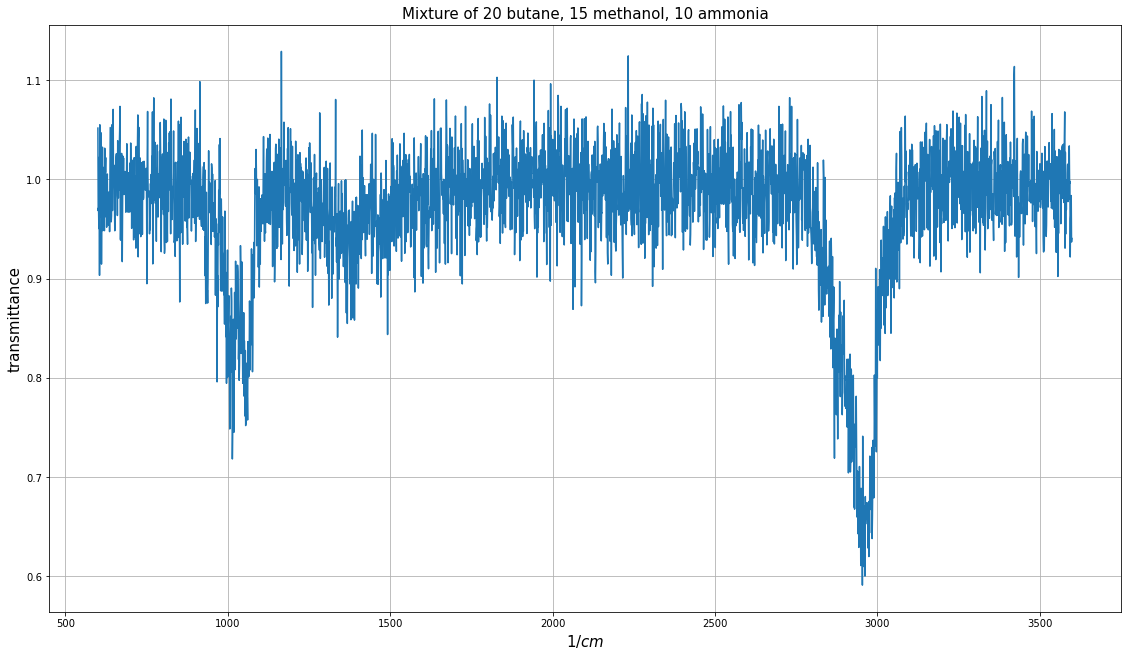

In [31]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes()
ax.plot(specs.x, mixture)
ax.set_xlabel('$1/cm$', fontsize=15)
ax.set_ylabel('transmittance', fontsize=15)
ax.set_title('Mixture of 20 butane, 15 methanol, 10 ammonia', fontsize=15)
ax.grid(True)
# fig.savefig('./results/task3.png', dpi=600, format='png')

In [32]:
predictor_bas = substance_predictor(mixture, specs.drop('x', axis=1), minimize_type='bas', c_true=task3_conc)
predictor_bas.fit()
predictor_bas.predict()

Метод:Отжиг
Вещество:butane,
Концентрация:19.837995894328564
Относительная ошибка:0.81%
~~~~~~~~~~~~~~~~~~~~
Вещество:methanol,
Концентрация:14.793442241589633
Относительная ошибка:1.377%
~~~~~~~~~~~~~~~~~~~~
Вещество:ammonia,
Концентрация:9.458126336136555
Относительная ошибка:5.419%
~~~~~~~~~~~~~~~~~~~~


In [33]:
predictor_bas = substance_predictor(mixture, specs.drop('x', axis=1), minimize_type='gd', c_true=task3_conc)
predictor_bas.fit()
predictor_bas.predict()

Метод:Градиентный спуск
Вещество:butane,
Концентрация:19.830884250841013
Относительная ошибка:0.846%
~~~~~~~~~~~~~~~~~~~~
Вещество:methanol,
Концентрация:14.793185868885121
Относительная ошибка:1.379%
~~~~~~~~~~~~~~~~~~~~
Вещество:ammonia,
Концентрация:9.457529863111597
Относительная ошибка:5.425%
~~~~~~~~~~~~~~~~~~~~


## Задание №4

In [34]:
task4_specs = '1-butanol'

In [35]:
sample = specs[task4_specs].values
sample = make_noised(sample, 3)

In [36]:
def SAM(sample, base, return_cos=False):
    '''
    Метод классификации по косинусному расстоянию
    '''
    base_names = base.columns
    cos = []
    for spec in base_names:
        cos.append(cosine_distances(sample.reshape(1, -1), base[spec].values.reshape(1, -1))[0][0])
    answ_index = np.argmin(np.array(cos))
    if return_cos:
        return base_names[answ_index], cos[answ_index], cos
    return base_names[answ_index], cos[answ_index], answ_index

In [37]:
thresholds = np.arange(0.03, 0.05, 0.0005) # 0.0387
TPR = []
sample = specs[task4_specs].values

for threshold in tqdm(thresholds):
    TP = 0
    iter_ = 1
    while iter_ < 1000:
        iter_ += 1
        target = make_noised(sample, 3)
        res = SAM(target, specs)
        index = np.where(specs.columns == '1-butanol')[0][0]
        if res[1] <= threshold and res[2] == index:
            TP += 1
    TPR.append(TP / 1000)

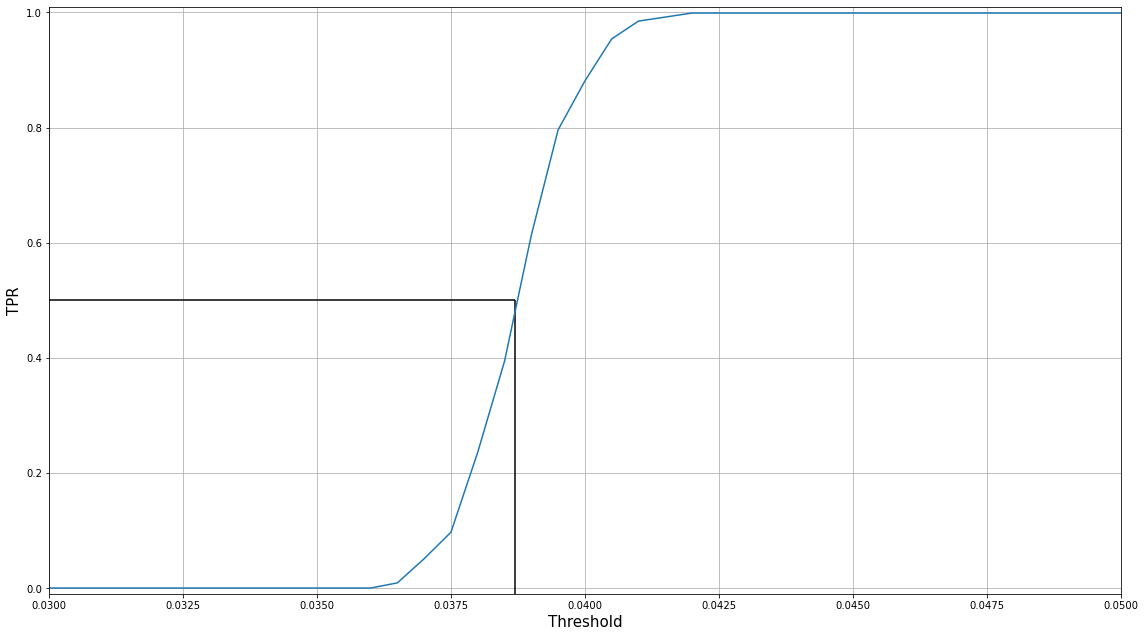

In [38]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes()
ax.plot(thresholds, TPR)
ax.vlines(0.0387, ymin=-0.01, ymax=0.5)
ax.hlines(0.5, xmin=0.03, xmax=0.0387)
ax.set_xlim([0.03, 0.05])
ax.set_ylim([-0.01, 1.01])
ax.set_xlabel('Threshold', fontsize=15)
ax.set_ylabel('TPR', fontsize=15)
ax.grid(True)
# fig.savefig('./results/task4.png', dpi=600, format='png')

## Задание №5

In [39]:
task5_specs = 'ammonia'
sample = specs[task5_specs].values

In [40]:
def SCM(sample, base):
    assert type(sample) == np.ndarray
    assert type(sample) == np.ndarray
    
    answ = np.array([], dtype=np.float32)
    for i in range(base.shape[1]):
        answ = np.hstack((answ, np.corrcoef(sample.reshape(-1), base[:, i].reshape(-1))[0][1]))
    coef = np.max(answ)
    index = np.argmax(answ)
    return coef, index

In [41]:
base = specs.drop('x', axis=1).values

In [42]:
slt = []
for i in tqdm(range(1000)):
    j = np.random.choice(10)
    sp = base[:, j].reshape(-1, 1)
    spec = make_noised(sample, 1)
    corr, _ = SCM(spec, sp)
    index = 1 if j == 8 else 0
    slt.append((index, corr))

In [43]:
fpr, tpr, thresholds = roc_curve(np.array(slt)[:, 0], np.array(slt)[:, 1])

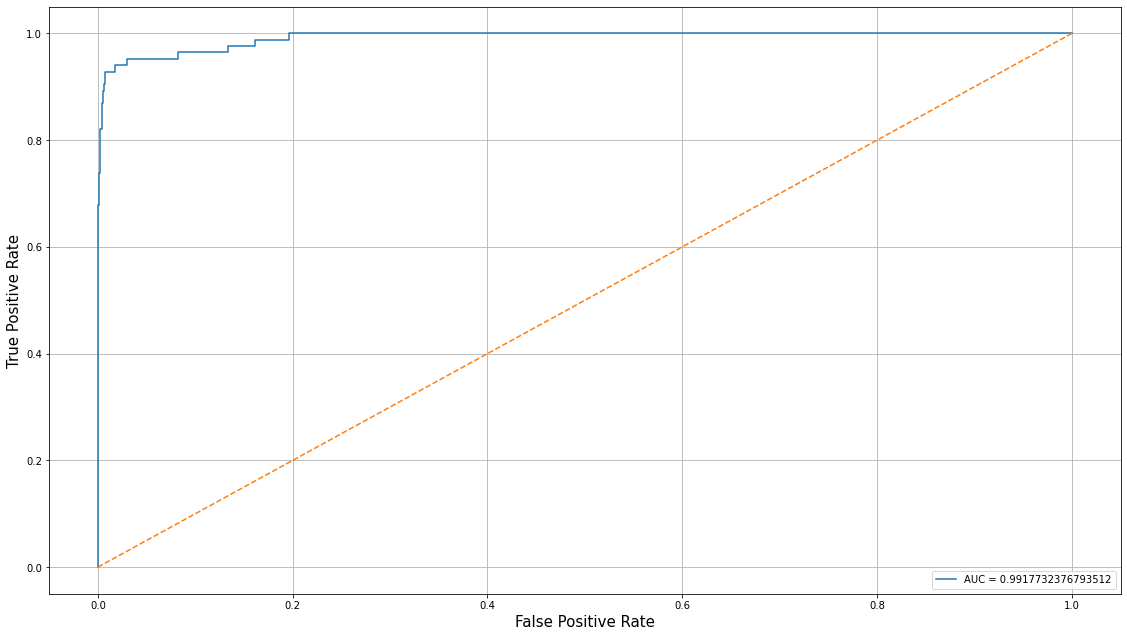

In [44]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes()
ax.plot(fpr, tpr, label='AUC = {}'.format(roc_auc_score(np.array(slt)[:, 0], np.array(slt)[:, 1])))
ax.plot([0, 1], [0, 1], '--')
ax.set_xlabel('False Positive Rate',fontsize=15)
ax.set_ylabel('True Positive Rate', fontsize=15)
ax.grid(True)
ax.legend(loc='lower right')
plt.show()
# fig.savefig('./results/task5_roc.png', dpi=600, format='png')

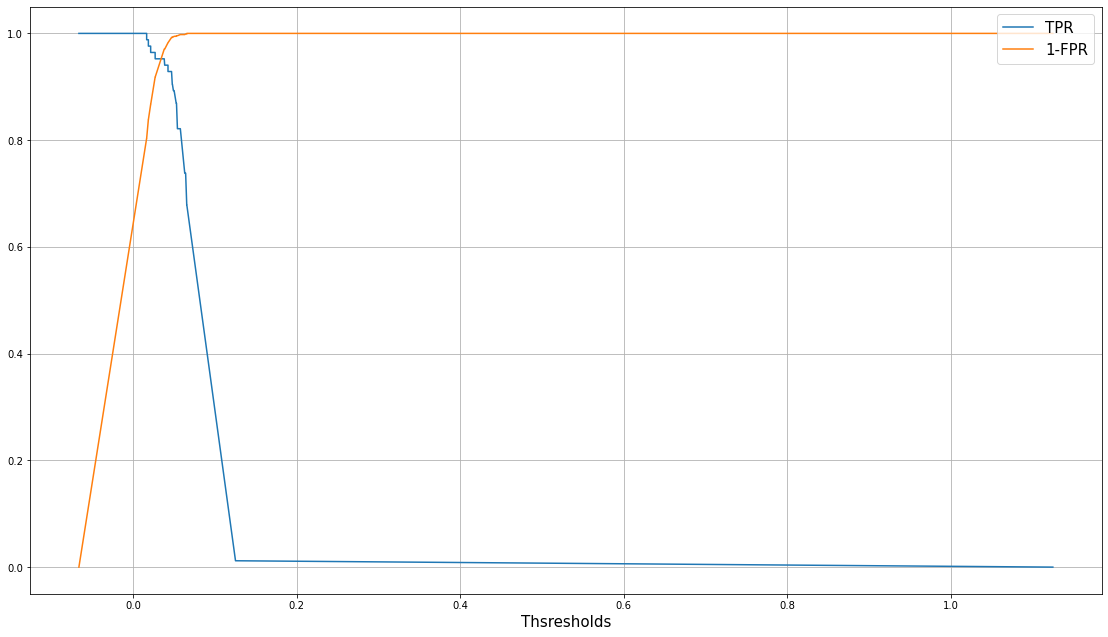

In [45]:
fig = plt.figure(figsize=(19.20, 10.80))
ax = plt.axes()
ax.plot(thresholds, tpr, label='TPR')
ax.plot(thresholds, 1 - fpr, label='1-FPR')
ax.set_xlabel('Thsresholds',fontsize=15)
ax.grid(True)
ax.legend(loc='upper right', fontsize=15)
plt.show()
# fig.savefig('./results/task5_thrshls.png', dpi=600, format='png')

In [46]:
metric = []
for i in range(len(fpr)):
    metric.append(np.sqrt(fpr[i]) ** 2 + (tpr[i] - 1) ** 2)
optimal_treshold = metric[np.where(metric == min(metric))[0][0]]
print(optimal_treshold)

0.012743962213706439
